## ５章　リカレントニューラルネットワーク（RNN）

**フィードフォワード**

　・流れが一方向のネットワークのこと

　・入力信号が次の層（隠れ層）へ信号を伝達し、その信号を受けとった層は、次の層に伝達し・・・　という感じ。

 　・単純な構成で、仕組みも理解しやすく、それでいて多くの問題に応用できる。

→だた、時系列データをうまく扱えない。より正確に言うと、時系列データの性質を十分に学習することができない。

ここで、登場したのが、*リカレントニューラルネットワーク（RNN）*。

##　5.1　確率と言語モデル

**言語モデル**

　・自然言語に関する現象を「確率」を用いて記述し、言語を確率として扱う。

<復習>　word2vecのCBOWモデル

##　5.2　RNNとは

**5.2.1　循環するニューラルネットワーク**

　次のような、「RNNレイヤ」について考える。

<img src="figures/IMG_6304.jpeg">

　RNNレイヤは、ループする経路を持つ。このループによって、データがレイヤ内を循環する。

　なお、$X_t$は、時刻tにおける入力で、ベクトルを想定。また、$h_t$はその出力。

**5.2 ループの展開**

<img src="figures/IMG_6305.jpeg">

　図のように、ループを展開することで一方向に進むニューラルネットワーク、つまり、フィードフォワード型ニューラルネットワークになる。

　この構造を、構成する複数の「RNNレイヤ」が、すべて「同じRNNレイヤ」であることが、これまでのニューラルネットワークとは異なる点。

　また、各時刻のRNNレイヤは、その入力の一つ前のRNNレイヤからの出力も受け取るので、その時刻の出力の計算は次のように行われる。

　　　**$h_t = tanh(h_{t-1}W_h + x_tW_x + b)$**

　$W_x$：入力ｘを出力ｈに変換するための重み。　　　$W_h$：一つ前のRNNの出力を次の時刻の出力に変換するための重み。　　　$b$：バイアス。

　$h_{t-1}$、$x_t$：行ベクトル。

　この式から、RNNは$h$という「状態」をもっていて、上の式の形で更新される　とも解釈できる。

　これが、RNNが「状態を持つレイヤ」、「メモリ・記憶力を持つレイヤ」と言われる所以である。

**5.2.3　Backpropagation　Through Time**

　RNNレイヤを展開することで、通常のニューラルネットワークと同じ手順で学習することができた。

<img src="figures/IMG_6306.jpeg">

　ループを展開した後のRNNは、通常の誤差逆伝播法を使うことができる。

　ここでの、誤差逆伝播法は「時間方向に展開したニューラルネットワークの誤差逆伝播法」ということで、”**Backpropagation Through Time・BPTT**”と呼ばれる。

　　→長い時系列データを学習する場合、データの時間サイズが大きくなるにつれてコンピュータの計算リソースが増加するのに加え、逆伝播時の勾配が不安定になる　という問題を抱えている。

**5.2.4　Truncated BPTT**

　大きな時系列データに対して、ネットワークの繋がりを適当な長さで”断ち切る”。

　その断ち切ってできた、小さなネットワークに対して、誤差逆伝播法を行う、これが”**Truncated BPTT**”。

　ここで重要なのは、断ち切るのは「逆伝播」のつながりだけで、順伝播のつながりは維持されたままであるということ。

　切り取られたネットワーク単位で学習する。

<img src="figures/IMG_6307.jpeg">

<img src="figures/IMG_6308.jpeg">

　2つの図を比較するとわかるように、順伝播の計算では前ブロックの隠れ状態$h_9$が必要である。

　同じ要領で、3つ目以降のブロックに対しても直前のブロックの隠れ状態を利用することで、順伝播のつながりを維持することができる。

<img src="figures/IMG_6309.jpeg">

**5.2.5　Truncated BPTTのミニバッチ学習**

　ここまでの話は、「バッチ」についてはかんがえていなかった。

　本来であれば、バッチを考慮し、図5-14のようにシーケンシャルにデータを与える必要があった。

　そのためには、データに与える開始位置を各バッチで”ズラす”必要がある。

 例として、次の1000個のデータを見る。

　バッチ数が２なら、開始位置を500だけズラしてあげる。

<img src="figures/IMG_6310.jpeg">

##　5.3　RNNの実装

**5.3.1　RNNレイヤの実装**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#RNNレイヤの実装
class RNN:
    def __int__(self, Wx, Wh, b):    #引数として重み2つとバイアス１つ
        self.params = [Wx, Wh, b]　　#引数をリスト化
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]　#各パラメータに対応する形で勾配を初期化
        self.cache = None　　　　　　　#逆伝播時の中間データを初期化

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b  #各層による重み付け
        h_next = np.tanh(t)　　　　　　　　#次時刻のレイヤへの入力

        self.cache = (x, h_prev, h_next)
        return h_next

　続いて、逆伝播の実装に進みましょう。

　次の図を参考に、コードを実装します。

<img src="figures/IMG_6311.jpeg">

In [15]:
class RNN:
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

**5.3.2 Time RNNレイヤの実装**

　Time RNNレイヤは、T個のRNNレイヤを連結したネットワーク。

　隠れ状態$h$をメンバ変数として保持することで、隠れ状態の”引き継ぎ”を行えるようにする。

<img src="figures/IMG_6312.jpeg">

In [19]:
class TimeRNN:
    def __int__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

　続いて、順伝播の実装。

In [20]:
class TimeRNN:
    def forward(self, xs):           #xsは、T個の時系列データをひとつにまとめたもの
        Wx, Wh, b = self.params
        N, T, D = xs.shape　　　　　　#バッチサイズはN個、入力ベクトルの次元数D
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')　　　　　#出力用の”容器”

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

       for t in range(T):
           layers = RNN(*self.params)　　　　#RNNレイヤが各時刻の隠れ状態を計算
           self.h = layer.forward(xs[:, t, :], self.h)
           hs[:, t, :] = self.h
           self.layers.append(layer)
    
       return hs

　続いて、Time RNNレイヤの逆伝播の実装。

　先ほどのRNNの逆伝播の実装と同様に、次の図を参考に実装する。

　ここでは、Truncated BPTTを考えるので、前の時刻の逆伝播は必要ない。ただし、前時刻への隠れ状態の勾配はメンバ変数の$dh$に保持することにする。

<img src="figures/IMG_6313.jpeg">

　$t$番目のRNNレイヤに着目すると、次の図のようになる。

　上からの勾配$dh_t$と「ひとつ未来のレイヤ」からの勾配$dh_{next}$が伝わる。

　つまり、RNNレイヤの順伝播では出力が2つに分岐しているということです。

<img src="figures/IMG_6314.jpeg">

In [24]:
class TimeRNN:
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layers = self.layers[t]
            dx, dh = layers.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
                    
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

　以上が、Time RNNレイヤの実装の説明でした。

##　5.4　時系列データを扱うレイヤの実装

　先ほどまでは、時系列データをまとめて処理するーTime RNNレイヤーを実装してきた。

　ここからは、RNNによる言語モデルーRNN Language Model・RNNLMーを構成する

**5.4.1　RNNLMの全体図**

　下の図が、最もシンプルなRNNLMのネットワーク図である。

<img src="figures/IMG_6315.jpeg">

　Embeddingレイヤ　ー　単語IDを単語の分散表現(単語ベクトル)へと変換する。この分散表現が、RNNレイヤへ入力される。

　RNNレイヤ　ー　隠れ状態を次の層(図の上方向)へ出力すると同時に、次時刻のRNNレイヤ(図の右方向)へ出力する。

　RNNレイヤが出力した隠れ状態は、Affineレイヤを経て、Softmaxレイヤへ伝わる。

　おなじみの「You say goodbye and I say hello」を用いて、ニューラルネットワークに対する順伝播を考える。

　RNNLMが行う処理は、以下のようになる。

<img src="figures/IMG_6316.jpeg">

　最初の時刻に注目します。

　ここでは、単語IDが０、つまり、「you」が入力される。

　Softmaxレイヤによって出力される確率分布を見ると、「say」で最も高くなっている。

　次に、「say」を入力する箇所を見ると、出力は「goodbye」と「hello」の２箇所で高くなっている。

　これは、RNNレイヤは、「you say」という文脈を記憶しているということ。

**５.４.２　Timeレイヤの実装**

　時系列データをまとめるとき同様、ここでも、Time EmbeddingレイヤやTime Affineレイヤという名前で実装する。

In [27]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [28]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx
        

　Softmaxについては、損失誤差のCross Entropy Errorレイヤも合わせた、Time Softmax with Lossとして実装する。

<img src="figures/IMG_6317.jpeg">

　$x_0$や$x_1$などは、下の層から伝わる「スコア」を表す。また、$t_0$や$t_1$などは、正解ラベルを表す。

　T個のSoftmax with Lossレイヤで、それぞれ損失を計算し、それらを合算、平均をとったものを最終的な損失とする。

　　　　$L = \frac{1}{T} (L_0 + L_1 + ・・・ + L_{T-1})$

In [30]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_labelに該当するデータは損失を0にする
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelに該当するデータは勾配を0にする

        dx = dx.reshape((N, T, V))

        return dx

## 5.5 RNNLMに学習と評価

　RNNLMの実装に必要なレイヤは揃いました。

　実際に、RNNレイヤを実装して、学習させてみましょう。

**５.５.１　RNNLMの実装**

　RNNLMで使用するネットワークを”SimoleRnnlm”というクラスで実装する。

　下の図は、SimpleRnnlmのレイヤ構成

<img src="figures/IMG_6318.jpeg">

In [44]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

 forrward()メソッド、backward()メソッド、reset_state()もまとめて実装する。

**5.5.2 言語モデルの評価**

　言語モデルの予測性能の良さを評価する指標として、パープレキシティがよく用いられる。簡単に言うと「確率の逆数」

　　　perplexity = $e^L$、　　　　　　　
   
   　　　$L = -\frac{1}{N} \Sigma_{n} \Sigma_{k} t_{nk} logy_{nk}$

　　　　　$t_{nk}$：n個目のデータのk番目の値、　　　$y_{nk}$：確率分布

　「you say goodbye and I say hello」を例に考える。

　モデル１の言語モデルに、「you」を与えたとき、「say」が正解だとすると、その確率は0.8。

　このときのパープレキシティは、$\frac{1}{0.8} = 1.25$と計算できる。

　パープレキシティは、小さければ小さいほどよい。また、パープレキシティの値は、「分岐数」と解釈できる。

　ここで、分岐数とは、次に出現しうる単語の候補の数。

<img src="figures/IMG_6319.jpeg">

**5.5.3　RNNLMの学習コード**

　PTBデータセットを用いて、RNNLMの学習を行う。

　ただし、今回はデータの先頭1000個の単語だけ利用する。

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 361.16
| epoch 2 | perplexity 243.30
| epoch 3 | perplexity 220.73
| epoch 4 | perplexity 215.22
| epoch 5 | perplexity 205.16
| epoch 6 | perplexity 201.21
| epoch 7 | perplexity 198.08
| epoch 8 | perplexity 196.44
| epoch 9 | perplexity 191.27
| epoch 10 | perplexity 192.77
| epoch 11 | perplexity 189.56
| epoch 12 | perplexity 192.44
| epoch 13 | perplexity 190.47
| epoch 14 | perplexity 190.57
| epoch 15 | perplexity 189.42
| epoch 16 | perplexity 186.22
| epoch 17 | perplexity 184.07
| epoch 18 | perplexity 180.64
| epoch 19 | perplexity 181.98
| epoch 20 | perplexity 184.79
| epoch 21 | perplexity 182.15
| epoch 22 | perplexity 178.97
| epoch 23 | perplexity 179.18
| epoch 24 | perplexity 180.16
| epoch 25 | perplexity 176.79
| epoch 26 | perplexity 177.43
| epoch 27 | perplexity 170.94
| epoch 28 | perplexity 170.20
| epoch 29 | perplexity 171.86
| epoch 30 | perplexity 164.98
| epoch 31 | perplexity 167.19
| e

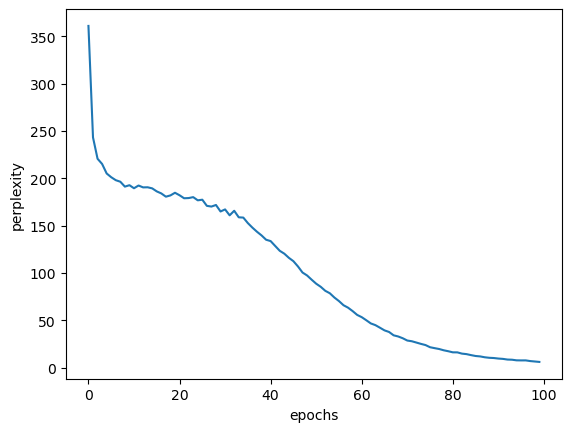

In [48]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from datasets import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

　パープレキシティははじめ300を超えていたが、最後の方は1に近づいている。

　ただ、今回は小さなデータセットを対象としていたが、コーパスが大きくなると太刀打ちできない。　　→　　次章で改良

**5.5.4　RNNLMのTrainerクラス**

　RNNLMTrainerを用いて、先ほどのコードを書き直す。

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 416.19
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 332.77
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 239.81
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 214.62
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 206.21
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 206.76
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 199.73
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.22
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.69
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.37
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.75
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 189.88
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 193.57
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 187.25
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 186.90
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 190.59
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 189.33
| epoch 18 |  iter 1 / 

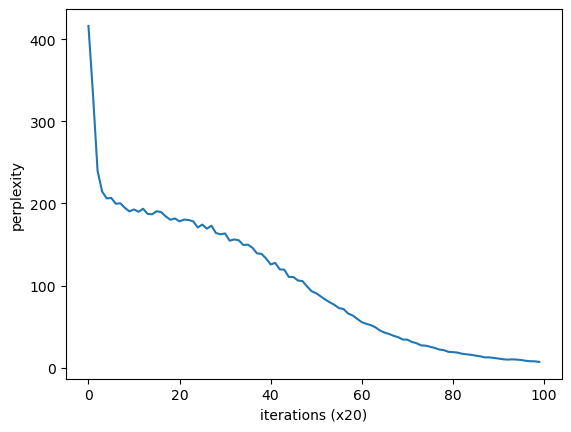

In [50]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from datasets import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

##　5.6　まとめ

　本章では、RNNレイヤ、およびTime RNNレイヤを実装した。

　RNNはデータを循環させることで、過去から現在、未来へとデータを継続して流す。

　RNNレイヤ内部に「隠れ状態」を記憶する能力を得る。

　それらを利用して、言語モデルを作成した。

　RNNを利用したニューラルネットワークを構成することで、”理論的には”どれだけ長い時系列データであっても重要な情報をRNNの隠れ状態に記憶することが可能になる。

　ただ、実際にはうまくいかないケースが多々ある。　　　→　　　新しいレイヤ　ー　LSTMレイヤやGPUレイヤ　ー　の登場。